<center>

# Logic, Learning, and Decision

## Home Assignment 1

### Synchronization and Supervisor Synthesis

- - -

# Introduction

The objective of this home assignment is to get a deeper understanding of some basic features of discrete event systems. This will be achieved by implementing a few key functions in Python, including the computation of coreachable states, the synchronous composition of two automata, as well as the synthesis of a nonblocking and controllable supervisor. These functions are then applied to the analysis of a simple coordination control system.

This home assignment is performed in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) containing your team's own original work on Canvas.**

## Comments and Recommendations

* As before, the following resources will be of great help to you for this assignment:
  * Lecture notes
  * [Python docs](https://docs.python.org/3/)
  * [Google](https://www.google.com)
  * [Wikipedia overview of syntax and semantics](https://en.wikipedia.org/wiki/Python_syntax_and_semantics) 
* We will work extensively with **sets** in this assignment: 
  * A set is created either through `set(*iterable*)` or by listing its elements between curly braces `{*iterable*}`; 
  * An empty set must be created by `set()`. `{}` will create an empty dictionary; 
  * You will also see often something like `{elem for elem in items if elem}`. This is called a *set comprehension* and builds efficiently a new set by iterating over `items` and adding the `elem` for which the if-statement is true; 
  * Have an extensive look at [the set documentation](https://docs.python.org/3/library/stdtypes.html#set) for more information on set methods. Use set methods as much as possible.  
* The assignment is written for Python 3.5 or later.
* If your code passes all the tests in this notebook, you are on a good way. That does not mean you have passed though! **We will test your code with additional edge cases.** So, convince yourself that everything is correct before you submit, e.g. *through your own test cases*.

- - -

# Data Structures

As in Assignment 0, we define the Transition and Automaton classes. They are structured the same as previously. We have included, however, a few validation methods that ensure that the Automaton is consistent at all time. You do not need to change anything here, but give it a thorough read anyway.  

In [3]:
from collections import namedtuple

from util import plot_automaton


Transition = namedtuple(typename='Transition', field_names=[
                        'source', 'event', 'target'])


class Automaton(object):

    def __init__(self, states, init, events, trans, marked=None, forbidden=None):
        """
        This is the constructor of the automaton.

        At creation, the automaton gets the following attributes assigned:
        :param states: A set of states
        :param init: The initial state
        :param events: A set of events
        :param trans: A set of transitions
        :param marked: (Optional) A set of marked states
        :param forbidden: (Optional) A set of forbidden states
        """
        self.states = states
        self.init = init
        self.events = events
        self.trans = trans
        self.marked = marked if marked else set()
        self.forbidden = forbidden if forbidden else set()

    def __str__(self):
        """
        Prints the automaton in a pretty way.
        """
        return 'states: \n\t{}\n' \
               'init: \n\t{}\n' \
               'events: \n\t{}\n' \
               'transitions: \n\t{}\n' \
               'marked: \n\t{}\n' \
               'forbidden: \n\t{}\n'.format(
                   self.states, self.init, self.events,
                   '\n\t'.join([str(t) for t in self.trans]), self.marked, self.forbidden)

    def __setattr__(self, name, value):
        """Validates and protects the attributes of the automaton"""
        if name in ('states', 'events'):
            value = frozenset(self._validate_set(value))
        elif name == 'init':
            value = self._validate_init(value)
        elif name == 'trans':
            value = frozenset(self._validate_transitions(value))
        elif name in ('marked', 'forbidden'):
            value = frozenset(self._validate_subset(value))
        super(Automaton, self).__setattr__(name, value)

    def __getattribute__(self, name):
        """Returns a regular set of the accessed attribute"""
        if name in ('states', 'events', 'trans', 'marked', 'forbidden'):
            return set(super(Automaton, self).__getattribute__(name))
        else:
            return super(Automaton, self).__getattribute__(name)

    def __eq__(self, other):
        """Checks if two Automata are the same"""
        if type(other) is type(self):
            return self.__dict__ == other.__dict__
        return False

    @staticmethod
    def _validate_set(states):
        """Checks that states is a set and the states in it are strings or integers"""
        assert isinstance(states, set)
        for state in states:
            assert isinstance(state, str) or isinstance(
                state, int), 'A state must be either of type string or integer!'
        return states

    def _validate_subset(self, subset):
        """Validates the set and checks whether the states in the subset are part of the state set"""
        subset = self._validate_set(subset)
        assert subset.issubset(
            self.states), 'Marked and forbidden states must be subsets of all states!'
        return subset

    def _validate_init(self, state):
        """Checks whether the state is part of the state set"""
        assert isinstance(state, str) or isinstance(
            state, int), 'The initial state must be of type string or integer!'
        assert state in self.states, 'The initial state must be member of states!'
        return state

    def _validate_transitions(self, transitions):
        """Checks that all transition elements are part in the respective sets (states, events)"""
        assert isinstance(transitions, set)
        for transition in transitions:
            assert isinstance(transition, Transition)
            assert transition.source in self.states
            assert transition.event in self.events
            assert transition.target in self.states
        return transitions

- - -

# Task 1

## Reachability ***[1p]***

To start with, we revisit a few of the functions that you have implemented already in the previous assignment. Whereas Assignment 0 was intended to provide you with a test bench for programming in Python and developing algorithmic understanding, this task is to ensure that you got a correct implementation of `reach` for the rest of the assignment. You might be able to copy your previous solution here. 

A reachability algorithm based on set logic is as follows:

**Algorithm 1.** Reachability($\Sigma, \delta, Q_0, Q_x$)

>**let** $k:=0, Q_0 := Q_0 \setminus Q_x$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q^+ \mid \exists q \in Q_{k-1} \wedge \exists \sigma \in \Sigma \wedge \delta(q,\sigma) = q^+ \} \setminus Q_x $
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

This algorithm is a so called fix point operation. We want you to implement a version of this algorithm. Check the lecture notes for further explanation. Other implementations, that use e.g. a recursion, will not be accepted even if correct.


Here are some helper functions that might help you with your implementation of the algorithm in code.

In [4]:
def filter_trans_by_source(trans, states_to_keep):
    """Returns a new set containing all transitions where the source is in states_to_keep"""
    return {t for t in trans if t.source in states_to_keep}

def filter_trans_by_events(trans, events_to_keep):
    """Returns a new set containing all transitions where the event is in events_to_keep"""
    return {t for t in trans if t.event in events_to_keep}

def filter_trans_by_target(trans, states_to_keep):
    """Returns a new set containing all transitions where the target is in states_to_keep"""
    return {t for t in trans if t.target in states_to_keep}

def extract_elems_from_trans(trans, field):
    """ 
    Returns a new set with just the elements in a field of all transitions. 
    E.g. field='source' for all source states 
    or field='event' or field='target'
    """
    return {getattr(t, field) for t in trans}

def flip_trans(trans):
    """ Flips the direction of the transitions in the set"""
    return {Transition(t.target, t.event, t.source) for t in trans}

In [5]:
# Now implement the function in code
def reach(events, trans, start_states, forbidden):
    """
    Returns the forward reachable states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """

    Q = start_states - forbidden

    while True:
        delta = filter_trans_by_source(trans, Q)
        delta = filter_trans_by_events(delta, events)
        q_plus = extract_elems_from_trans(delta, 'target')
        q_plus = q_plus - forbidden

        if not q_plus - Q:
            break

        Q.update(q_plus)

    return Q

As before, the below is a test cell. You can execute it to test your function with different inputs. The **assert** statements make sure that your function returns the expected results. We encourage you to add also your own tests.

In [6]:
# Space for your own tests
# No start states
reachable = reach({'a'}, {Transition(1,'a',2)}, set(), set())
assert reachable == set()

# Events empty but transitions exist -> ignore edges
reachable = reach(set(), {Transition(1,'a',2)}, {1}, set())
assert reachable == {1}

# Transitions exist but their events not in Σ
reachable = reach({'b'}, {Transition(1,'a',2)}, {1}, set())
assert reachable == {1}

# Multiple start states
reachable = reach({'a','b'},
                  {Transition(1,'a',2), Transition(2,'b',3), Transition(3,'b',4)},
                  {1, 99},
                  set())
assert reachable == {1,2,3,4,99}

# Multiple targets for same source and event
reachable = reach({'a'},
                  {Transition(1,'a',2), Transition(1,'a',3)},
                  {1},
                  set())
assert reachable == {1,2,3}

# Ignore disconnected components
reachable = reach({'a'},
                  {Transition(10,'a',11)},  # unreachable island
                  {1},
                  set())
assert reachable == {1}

# Forbidden blocking the path
reachable = reach({'a'},
                  {Transition(1,'a',2), Transition(2,'a',3)},
                  {1},
                  {2})
assert reachable == {1}

# Start states same as forbidden
reachable = reach({'a'}, {Transition(1,'a',2)}, {1}, {1})
assert reachable == set()

reachable = reach({'a'}, {Transition(1,'a',2)}, {1,2}, {1,2})
assert reachable == set()

# Self loops
reachable = reach({'a'},
                  {Transition(1,'a',1), Transition(1,'a',2), Transition(2,'a',2)},
                  {1},
                  {2})
assert reachable == {1}

# Non int state variables
reachable = reach({'go'},
                  {Transition('s','go','t'), Transition('t','go','u')},
                  {'s'},
                  set())
assert reachable == {'s','t','u'}




In [7]:
# Single state
reachable = reach(set(), set(), {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(1, 'a', 1)}, {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)

# Simple automata
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, set())
assert reachable == {1, 2}, 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(2, 'a', 1)}, {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set())
assert reachable == {1, 2}, 'Got {} instead'.format(reachable)

# Parallel transitions
reachable = reach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set())
assert reachable == {1, 2}, 'Got {} instead'.format(reachable)
reachable = reach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set())
assert reachable == {1}, 'Got {} instead'.format(reachable)

# Handling of forbidden states
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, {1})
assert reachable == set(), 'Got {} instead'.format(reachable)
reachable = reach({'a'}, {Transition(1, 'a', 2)}, {1}, {2})
assert reachable == {1}, 'Got {} instead'.format(reachable)

# Larger automata
reachable = reach({'a'},
                  {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
                  {1},
                  set())
assert reachable == {1, 2, 3}, 'Got {} instead'.format(reachable)

The set of backwards reachable states can now be obtained as follows:

In [8]:
def coreach(events, trans, start_states, forbidden):
    """
    Returns the coreachable (backward reachable) states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    return reach(events, flip_trans(trans), start_states, forbidden)

- - -

# Task 2

## Synchronous composition ***[3p]***
* Implement the synchronous composition of two automaton. Exclude all unreachble states in the result.

* *Note:* The synchronization function can be implemented in different ways. We suggest to loop through all events, taking common and individual events for the two automata into account. In this event loop appropriate states are merged together according to the basic definition. A number of unreachable states will then be included.   
* *Note:* The synchronized function shall include the complete automaton, including any marked and forbidden states of the synchronized automaton.

Here are again some helper functions that might help you with your implementation of the algorithm in code.

In [9]:
def merge_label(label1, label2):
    """Creates a new label based on two labels"""
    return '{}.{}'.format(label1, label2)

def cross_product(setA, setB):
    """Computes the crossproduct of two sets"""
    return {merge_label(a, b) for b in setB for a in setA}

In [10]:
def synch(aut1, aut2):
    """
    Returns the synchronous composition of two automata.
    
    :param aut1: Automaton
    :param aut2: Automaton
    """

    # Combined state set
    Q = cross_product(aut1.states, aut2.states)

    # Init state
    init_s = merge_label(aut1.init, aut2.init)

    # Marked states, if input empty set all states as marked
    Qm_1 = aut1.states if not aut1.marked else aut1.marked
    Qm_2 = aut2.states if not aut2.marked else aut2.marked
    Qm = cross_product(Qm_1, Qm_2)

    # Forbidden states
    Qx = cross_product(aut1.forbidden, aut2.states) | cross_product(aut1.states, aut2.forbidden)

    # Events
    sigma = aut1.events | aut2.events
    shared = aut1.events & aut2.events
    local1 = aut1.events - aut2.events
    local2 = aut2.events - aut1.events

    # Transitions for shared and local events
    delta = set()

    # Loop through shared and local events respectively to get all transitions
    # Shared events
    t1_shared = filter_trans_by_events(aut1.trans, shared)
    t2_shared = filter_trans_by_events(aut2.trans, shared)
    for t1 in t1_shared:
        # keep same-event pairs only
        for t2 in filter_trans_by_events(t2_shared, {t1.event}):
            src = merge_label(t1.source, t2.source)
            tgt = merge_label(t1.target, t2.target)
            delta.add(Transition(src, t1.event, tgt))

    # Local events for automaton 1
    for t1 in filter_trans_by_events(aut1.trans, local1):
        for q2 in aut2.states:
            src = merge_label(t1.source, q2)
            tgt = merge_label(t1.target, q2)
            delta.add(Transition(src, t1.event, tgt))

    # Local events for automaton 2
    for t2 in filter_trans_by_events(aut2.trans, local2):
        for q1 in aut1.states:
            src = merge_label(q1, t2.source)
            tgt = merge_label(q1, t2.target)
            delta.add(Transition(src, t2.event, tgt))

    reachQ = reach(sigma, delta, {init_s}, forbidden=set())
    delta  = {t for t in delta if t.source in reachQ and t.target in reachQ}
    Q = reachQ
    Qm = Qm & reachQ
    Qx = Qx & reachQ

    aut1aut2 = Automaton(states=Q, events=sigma, init=init_s, trans=delta, marked=Qm, forbidden=Qx)
    return aut1aut2

# Test the synch function with 2 automata
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd', 'e'},
               init='c',
               events={1, 2},
               trans={Transition('c', 1, 'd'), Transition('d', 2, 'e'), Transition('e', 1, 'c')})
b1b2 = synch(b1, b2)
print(b1b2)

states: 
	{'a.c', 'b.e', 'b.d'}
init: 
	a.c
events: 
	{1, 2}
transitions: 
	Transition(source='b.d', event=2, target='b.e')
	Transition(source='a.c', event=1, target='b.d')
marked: 
	{'b.e', 'b.d'}
forbidden: 
	set()



In [11]:
# Space for your own tests

# Union of alphabets; 'a' private and enabled, 'b' shared but disabled in A
a1 = Automaton(states={1}, init=1, events={'a', 'b'},
               trans={Transition(1, 'a', 1)})
a2 = Automaton(states={3, 4}, init=3, events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.events == {'a', 'b'}
assert a1a2.states == {'1.3'}
assert a1a2.trans == {Transition('1.3', 'a', '1.3')}

# Private event works, making it shared-but-undefined blocks it
a1 = Automaton(states={1, 2}, init=1, events={'c'},
               trans={Transition(1, 'c', 2)})
a2 = Automaton(states={3}, init=3, events=set(), trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'c'}
assert a1a2.states == {'1.3', '2.3'}
assert Transition('1.3', 'c', '2.3') in a1a2.trans

a2 = Automaton(states={3}, init=3, events={'c'}, trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'c'}
assert a1a2.states == {'1.3'}
assert a1a2.trans == set()

# Unreachable state
a1 = Automaton(states={1, 9}, init=1, events={'a'},
               trans={Transition(9, 'a', 9)})
a2 = Automaton(states={2}, init=2, events=set(), trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'a'}
assert a1a2.states == {'1.2'}
assert all(not s.startswith('9') for s in a1a2.states)

# No marked set on one side, treat all its states as marked
a1 = Automaton(states={1, 2}, init=1, events={'a'},
               trans={Transition(1, 'a', 2)}, marked={2})
a2 = Automaton(states={3}, init=3, events=set(), trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'a'}
assert a1a2.states == {'1.3', '2.3'}
assert a1a2.marked == {'2.3'}

# Both sides marked, only the pair marked in both is marked in the product
a1 = Automaton(states={1, 2}, init=1, events={'a'},
               trans={Transition(1, 'a', 2)}, marked={2})
a2 = Automaton(states={3, 4}, init=3, events={'b'},
               trans={Transition(3, 'b', 4)}, marked={4})
a1a2 = synch(a1, a2)
assert a1a2.events == {'a', 'b'}
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'}
assert a1a2.marked == {'2.4'}

# Initial can be forbidden but must remain in the product
a1 = Automaton(states={1}, init=1, events=set(), trans=set(), forbidden={1})
a2 = Automaton(states={2}, init=2, events=set(), trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == set()
assert a1a2.states == {'1.2'}
assert a1a2.init == '1.2'
assert a1a2.trans == set()
assert a1a2.forbidden == {'1.2'}

# Forbidden propagates: any pair with a forbidden component is forbidden
a1 = Automaton(states={1, 2}, init=1, events={'a'},
               trans={Transition(1, 'a', 2)}, forbidden={2})
a2 = Automaton(states={3, 5}, init=3, events={'b'},
               trans={Transition(3, 'b', 5)}, forbidden={5})
a1a2 = synch(a1, a2)
assert a1a2.events == {'a', 'b'}
assert a1a2.states == {'1.3', '2.3', '1.5', '2.5'}
assert a1a2.forbidden == {'2.3', '1.5', '2.5'}
assert '1.3' in a1a2.states and '1.3' not in a1a2.forbidden

# Reachable-but-forbidden stays in the synched automaton
a1 = Automaton(states={1, 2}, init=1, events={'a'},
               trans={Transition(1, 'a', 2)}, forbidden={2})
a2 = Automaton(states={3}, init=3, events=set(), trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'a'}
assert a1a2.states == {'1.3', '2.3'}
assert a1a2.forbidden == {'2.3'}

# A synched with A for this A yields only diagonal states
a1 = Automaton(states={1, 2}, init=1, events={'a'},
               trans={Transition(1, 'a', 2)})
a1a1 = synch(a1, a1)
assert a1a1.events == {'a'}
assert a1a1.states == {'1.1', '2.2'}
assert a1a1.trans == {Transition('1.1', 'a', '2.2')}

# Duplicate input transitions do not create duplicates in the product
a1 = Automaton(states={1}, init=1, events={'a'},
               trans={Transition(1, 'a', 1), Transition(1, 'a', 1)})
a2 = Automaton(states={2}, init=2, events=set(), trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'a'}
assert a1a2.states == {'1.2'}
assert a1a2.trans == {Transition('1.2', 'a', '1.2')}

# Shared event with no defined transition on either side yields no edge
a1 = Automaton(states={1}, init=1, events={'a'}, trans=set())
a2 = Automaton(states={2}, init=2, events={'a'}, trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'a'}
assert a1a2.states == {'1.2'}
assert a1a2.trans == set()

# Union of events kept even if none is enabled at the initial states
a1 = Automaton(states={1}, init=1, events={'d'}, trans=set())
a2 = Automaton(states={2}, init=2, events={'e'}, trans=set())
a1a2 = synch(a1, a2)
assert a1a2.events == {'d', 'e'}
assert a1a2.states == {'1.2'}
assert a1a2.trans == set()



In [12]:
# Two 1-state automata
a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set())
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 1.1
assert a1a2.init == '1.2'  # TC - 1.2
assert a1a2.events == set()  # TC - 1.3
assert a1a2.trans == set()  # TC - 1.4

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               marked={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 2.1
assert a1a2.init == '1.2'  # TC - 2.2
assert a1a2.events == set()  # TC - 2.3
assert a1a2.trans == set()  # TC - 2.4
assert a1a2.marked == {'1.2'}  # TC - 2.5

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               forbidden={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 3.1
assert a1a2.init == '1.2'  # TC - 3.2
assert a1a2.events == set()  # TC - 3.3
assert a1a2.trans == set()  # TC - 3.4
assert a1a2.forbidden == {'1.2'}  # TC - 3.5

# 2-state automaton and 1-state automaton
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 4.1
assert a1a2.init == '1.3'  # TC - 4.2
assert a1a2.events == {'a'}  # TC - 4.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 4.4
assert a1a2.marked == {'2.3'}  # TC - 4.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 5.1
assert a1a2.init == '1.3'  # TC - 5.2
assert a1a2.events == {'a'}  # TC - 5.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 5.5
assert a1a2.forbidden == {'2.3'}  # TC - 5.6

# Two 2-state automata
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'}  # TC - 6.1
assert a1a2.init == '1.3'  # TC - 6.2
assert a1a2.events == {'a', 'b'}  # TC - 6.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition(
    '1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')}  # TC -6.4
assert a1a2.marked == {'2.3', '2.4'}  # TC - 6.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'a'},
               trans={Transition(3, 'a', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.4'}  # TC - 7.1
assert a1a2.init == '1.3'  # TC - 7.2
assert a1a2.events == {'a'}  # TC - 7.3
assert a1a2.trans == {Transition('1.3', 'a', '2.4')}  # TC - 7.4
assert a1a2.marked == {'2.4'}  # TC - 7.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)},
               forbidden={4})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'}  # TC - 8.1
assert a1a2.init == '1.3'  # TC - 8.2
assert a1a2.events == {'a', 'b'}  # TC - 8.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition(
    '1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')}  # TC - 8.4
assert a1a2.forbidden == {'2.3', '1.4', '2.4'}  # TC - 8.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 9.1
assert a1a2.init == '1.3'  # TC - 9.2
assert a1a2.events == {'a', 'b'}  # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 9.4
assert a1a2.marked == {'2.3'}  # TC - 9.5

# Different symbols
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1, 2},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd'},
               init='c',
               events={2},
               trans={Transition('c', 2, 'd')})
b1b2 = synch(b1, b2)
assert b1b2.states == {
    'a.c', 'b.c'}, 'Different symbols should not cause error!'
assert b1b2.init == 'a.c', 'Different symbols should not cause error!'
assert b1b2.events == {1, 2}, 'Different symbols should not cause error!'
assert b1b2.trans == {Transition(
    'a.c', 1, 'b.c')}, 'Different symbols should not cause error!'
assert b1b2.marked == {'b.c'}, 'Different symbols should not cause error!'

- - -

# Task 3

## Verification ***[2p]***

Consider the following two plant models given by the formal languages

\begin{split}
    L(P_1) &= \overline{(ab)^*} \\ 
    L(P_2) &= \overline{(c(d+e))^*} 
\end{split}

and the marked specification languages 

\begin{split}
    L_m(Sp_1) &= (bc)^* \\ 
    L_m(Sp_2) &= (cd)^* 
\end{split}

and the synchronised system

<center>
    $S = P_1 \parallel P_2 \parallel Sp_1 \parallel Sp_2$

## Task 3.1 - Blocking States

* Generate the automaton for the synchronized system *S* by the implemented functions `synch`. Then, calculate the reachable and coreachable states in *S* by the implemented functions `reach` and `coreach`, and identify blocking states (states from where no marked state can be reached). ***[1p]***
* _Note_: Please follow the naming convention `%M%S` for the states of your automata, where
    * `%M` is the name of the model, i.e. one of `{'p1', 'p2', 'sp1', 'sp2'}`,
    * `%S` is the number of the state in the automata, such that
    * `'p11'` would be the first state in the automaton of the plant language $L(P_1)$ and
    * `'sp12'` would be the second state in the automaton of the marked language $L_m(Sp_1)$.

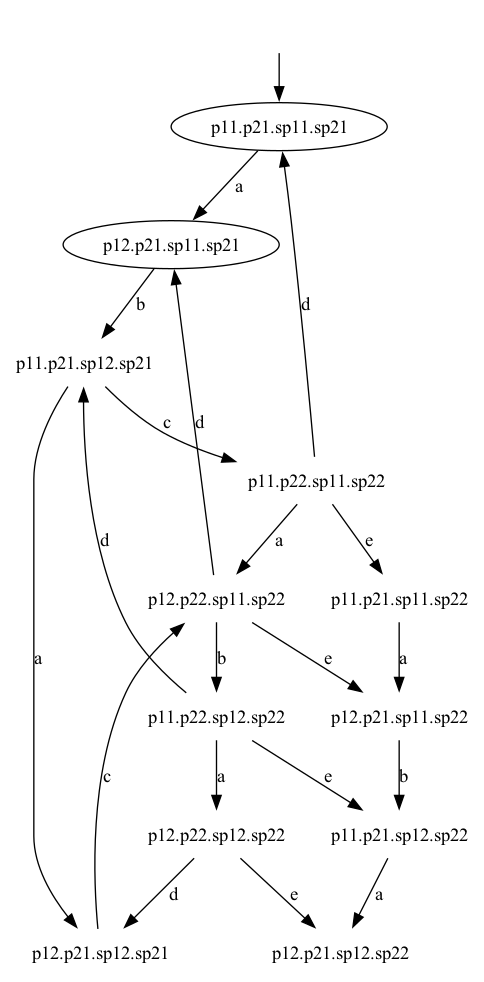

In [13]:
def make_synchronized_automaton_S():
    """
    A little helper function to create the automaton of S.

    Define the automata p1, p2, sp1 and sp2 in here too.
    We will call this function later in the tests.
    """
    p1 = Automaton({'p11', 'p12'}, 'p11', {'a', 'b'}, {Transition('p11', 'a', 'p12'), Transition('p12', 'b', 'p11')})
    p2 = Automaton({'p21', 'p22'}, 'p21', {'c', 'd', 'e'}, {Transition('p21', 'c', 'p22'), Transition('p22', 'd', 'p21'), Transition('p22', 'e', 'p21')})
    sp1 = Automaton({'sp11', 'sp12'}, 'sp11', {'b', 'c'}, {Transition('sp11', 'b', 'sp12'), Transition('sp12', 'c', 'sp11')}, {'sp11'})
    sp2 = Automaton({'sp21', 'sp22'}, 'sp21', {'c', 'd'}, {Transition('sp21', 'c', 'sp22'), Transition('sp22', 'd', 'sp21')}, {'sp21'})

    p1p2 = synch(p1, p2)
    sp1sp2 = synch(sp1, sp2)

    S = synch(p1p2, sp1sp2)

    return S

S = make_synchronized_automaton_S()

assert S.init == 'p11.p21.sp11.sp21', 'Please, follow this state naming convention and synchronization order!'

plot_automaton(S, 'P1P2SP1SP2')

In [14]:
reachable = None
coreachable = None 
blocking = None
# YOUR CODE HERE
reachable = reach(S.events, S.trans, {S.init}, S.forbidden)
coreachable = coreach(S.events, S.trans, S.marked, S.forbidden)
blocking = reachable - coreachable

print('The blocking states are: ', blocking)

The blocking states are:  {'p12.p21.sp11.sp22', 'p12.p21.sp12.sp22', 'p11.p21.sp11.sp22', 'p11.p21.sp12.sp22'}


In [15]:
assert type(make_synchronized_automaton_S()) is Automaton
assert reachable is not None
assert coreachable is not None
assert blocking is not None

## Task 3.2 - Modified Spec

* Modify the specifications to avoid any blocking states, and verify that no blocking states are achieved by showing that the reachable and coreachable states of *S* are the same for the modified specifications. ***[1p]***

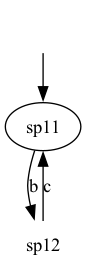

In [16]:
sp1_new = None

# YOUR CODE HERE

sp1_new = Automaton({'sp11', 'sp12'}, 'sp11', {'b', 'c', 'e'}, {Transition('sp11', 'b', 'sp12'), Transition('sp12', 'c', 'sp11')}, {'sp11'})

plot_automaton(sp1_new, 'SP1_new') 

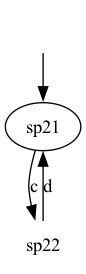

In [17]:
sp2_new = None

# YOUR CODE HERE

sp2_new = Automaton({'sp21', 'sp22'}, 'sp21', {'c', 'd', 'e'}, {Transition('sp21', 'c', 'sp22'), Transition('sp22', 'd', 'sp21')}, {'sp21'})

plot_automaton(sp2_new, 'SP2_new') 

The blocking states now are:  set()


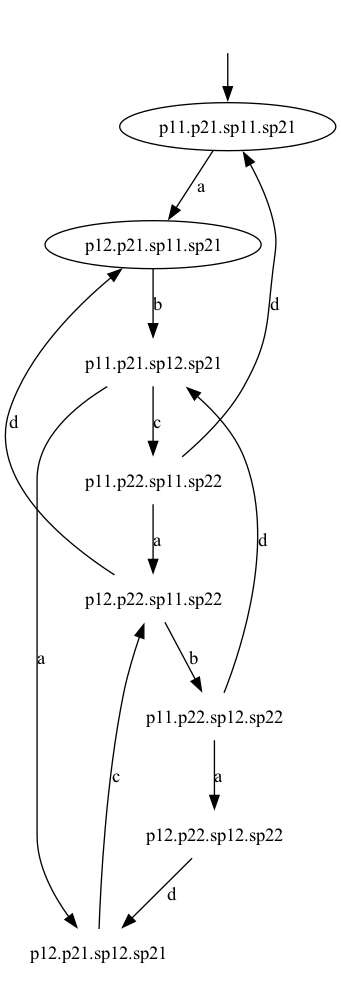

In [18]:
# Now synchronize with the new specifications
S_new = None
reachable_new = None
coreachable_new = None 
blocking_new = None
# YOUR CODE HERE
p1 = Automaton({'p11', 'p12'}, 'p11', {'a', 'b'}, {Transition('p11', 'a', 'p12'), Transition('p12', 'b', 'p11')})
p2 = Automaton({'p21', 'p22'}, 'p21', {'c', 'd', 'e'}, {Transition('p21', 'c', 'p22'), Transition('p22', 'd', 'p21'), Transition('p22', 'e', 'p21')})
S_new = synch(synch(p1, p2), synch(sp1_new, sp2_new))

reachable_new = reach(S_new.events, S_new.trans, {S_new.init}, S_new.forbidden)
coreachable_new = coreach(S_new.events, S_new.trans, S_new.marked, S_new.forbidden)
blocking_new = reachable_new - coreachable_new

print('The blocking states now are: ', blocking_new)
plot_automaton(S_new, 'S_new') 

In [19]:
assert type(S_new) is Automaton
assert reachable_new is not None
assert coreachable_new is not None
assert blocking_new is not None

- - -

# Task 4

## Synthesis ***[3p]***

Using `reach`, `coreach` and `synch`, your task is now to implement:

$\qquad$ `S = supervisor(P, Sp, sigma_u)`
    
that, given a plant $P$, a specification $Sp$ and a set of uncontrollable events $\Sigma_u$, generates a nonblocking and controllable supervisor $S$. Note that $\Sigma_u \subseteq \Sigma^P$, and it is assumed that $\Sigma^{Sp} \subseteq \Sigma^P$, where $\Sigma^P$ and $\Sigma^{Sp}$ are the event sets of the plant $P$ and the specification $Sp$. The supervisor is generated by implementing and applying algorithm 3 in the lecture notes.

Your code should raise a `ValueError` when there exist no supervisor that can fulfill the specification:

$\qquad$ `if noSupervisorExists: raise ValueError`

* *Note:* If more than one plant and/or specification model are involved, the total plant and/or specification model is generated by synchronizing the local models. For instance, $P_1, P_2, Sp_1$ and $Sp_2$ gives $P = P_1 \parallel P_2$ and $Sp = Sp_1 \parallel Sp_2$.

* *Note:* One of the input sets in Algorithm 3 is the set of forbidden states. Implement specifically a function that generates this forbidden state set, including both explicitly forbidden states and uncontrollable states.

* *Note:* In the synchronization of two automaton $A$ and $B$, the names of the original states $q^A$ and $q^B$ can be identified, since the merge state function generates state names $q^A.q^B$. Identification of the reachable states in $P \parallel Sp$ and the corresponding states in $P$ and $Sp$ simplifies the generation of the uncontrollable states. 

Here are some helper functions that might help you with your implementation of the algorithm in code.

In [20]:
# These two functions follow the definition of uncontrollable states given on page 100 in the Lecture Notes
def is_defined_for_p(p_trans, merged_source, shared_sigma_u):
    """
    Boolean check whether there is an uncontrollable transition defined in P
    with the merged_source as start state.
    
    :param p_trans: Set of transitions in automaton P
    :param merged_source: String label of the merged state in P||Q
    :param shared_sigma_u: Uncontrollable event shared between P and Q.
    """
    validate_inputs(p_trans, merged_source, shared_sigma_u)
    uncontrollable_trans = filter_trans_by_events(p_trans, shared_sigma_u)
    u_trans_from_merged_source = {t for t in uncontrollable_trans 
                                  if merged_source.startswith(str(t.source))}
    return u_trans_from_merged_source != set()


def is_defined_for_q(q_trans, merged_source, shared_sigma_u):
    """
    Boolean check whether there is an uncontrollable transition defined in Q
    with the merged_source as start state.
    
    :param q_trans: Set of transitions in automaton Q
    :param merged_source: String label of the merged state in P||Q
    :param shared_sigma_u: Uncontrollable event shared between P and Q.
    """
    validate_inputs(q_trans, merged_source, shared_sigma_u)
    uncontrollable_trans = filter_trans_by_events(q_trans, shared_sigma_u)
    u_trans_from_merged_source = {t for t in uncontrollable_trans 
                                  if merged_source.endswith(str(t.source))}
    return u_trans_from_merged_source != set()


def validate_inputs(trans, source, events):
    assert type(trans) is set
    assert all(type(t) is Transition for t in trans)
    
    assert type(source) is str

    assert type(events) is set
    assert all(type(e) in (str, int) for e in events)
    

In [23]:
# Now implement the function in code
def supervisor(P, Sp, sigma_u):
    """
    Generates a nonblocking and controllable supervisor for the synchronized system P||Sp.
    
    :param P: automaton of the plant
    :param Sp: automaton of the specification
    :param sigma_u: set of uncontrollable events
    """
    # YOUR CODE HERE
    S0 = synch(P, Sp)
    sigma_u_shared = sigma_u & P.events & Sp.events

    Quc = set()
    for ps in S0.states:
        if any(
            is_defined_for_p(P.trans, ps, {su}) and
            not is_defined_for_q(Sp.trans, ps, {su}) for su in sigma_u_shared
        ):
            Quc.add(ps)

    Qx = set(S0.forbidden) | Quc

    Qm = S0.marked if S0.marked else S0.states
    X = Qx
    while True:
        Q1 = coreach(S0.events, S0.trans, Qm, X)
        Q2 = coreach(sigma_u, S0.trans, S0.states - Q1, set())

        x_plus = X | Q2

        if x_plus == X:
            break

        X.update(x_plus) 
    
    Q_s = S0.states - X
    delta_s = { t for t in S0.trans if t.source in Q_s and t.target in Q_s}
    init_s = S0.init if S0.init else None
    Q_s = reach(S0.events, delta_s, {init_s}, X)
    marked_s = (Qm or set()) & Q_s

    if not Q_s or init_s not in Q_s:
        raise ValueError("No supervisor available")

    S = Automaton(Q_s, init_s, S0.events, delta_s, marked_s, set())

    return S

In [24]:
# Space for your own tests
# Uncontrollable event not shared (should have no effect)
P = Automaton(states={1, 2},
              init=1,
              events={'a', 'u'},
              trans={Transition(1, 'a', 2), Transition(2, 'u', 2)})
Sp = Automaton(states={1},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 1)})
S = supervisor(P, Sp, {'u'})
assert S.states == {'1.1', '2.1'}, 'TC 5.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 5.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'u'}, 'TC 5.3 - got {} instead'.format(S.events)

# Uncontrollable back-propagation with a branch
P = Automaton(states={1, 2, 3, 4},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2),        # controllable
                     Transition(2, 'a', 3),        # controllable
                     Transition(2, 'b', 4)})       # uncontrollable shared
Sp = Automaton(states={1, 2, 3},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2),
                      Transition(2, 'a', 3)})      # no 'b' from 2 → uncontrollable violation at 2
S = supervisor(P, Sp, {'b'})
assert S.states == {'1.1'}, 'TC 6.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 6.2 - got {} instead'.format(S.init)
assert S.trans == set(), 'TC 6.3 - got {} instead'.format(S.trans)

# No marked states given (all states treated as marked)
P = Automaton(states={1, 2},
              init=1,
              events={'a'},
              trans={Transition(1, 'a', 2)})
Sp = Automaton(states={1},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 1)})      # no explicit marked → supervisor treats all as marked
S = supervisor(P, Sp, set())
assert S.states == {'1.1', '2.1'}, 'TC 7.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 7.2 - got {} instead'.format(S.init)
assert S.events == {'a'}, 'TC 7.3 - got {} instead'.format(S.events)

# Forbidden in plant removes corresponding product states
P = Automaton(states={1, 2},
              init=1,
              events={'a'},
              trans={Transition(1, 'a', 2)},
              forbidden={2})
Sp = Automaton(states={1},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 1)})
S = supervisor(P, Sp, set())
assert S.states == {'1.1'}, 'TC 8.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 8.2 - got {} instead'.format(S.init)
assert S.trans == set(), 'TC 8.3 - got {} instead'.format(S.trans)

# Two different uncontrollables from same state
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b', 'c'},
              trans={Transition(1, 'a', 2),
                     Transition(2, 'b', 3),   # uncontrollable shared
                     Transition(2, 'c', 3)})  # uncontrollable shared
Sp = Automaton(states={1, 2},
               init=1,
               events={'a', 'b', 'c'},
               trans={Transition(1, 'a', 2)})    # spec defines neither b nor c at 2
S = supervisor(P, Sp, {'b', 'c'})
assert S.states == {'1.1'}, 'TC 9.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 9.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b', 'c'}, 'TC 9.3 - got {} instead'.format(S.events)

# Extra plant event unused by spec (shared controllable preserved)
P = Automaton(states={'p1', 'p2', 'p3'},
              init='p1',
              events={'x', 'y'},
              trans={Transition('p1', 'x', 'p2'), Transition('p2', 'y', 'p3')})
Sp = Automaton(states={'s1', 's2'},
               init='s1',
               events={'x'},
               trans={Transition('s1', 'x', 's2')})
S = supervisor(P, Sp, set())
assert S.states == {'p1.s1', 'p2.s2', 'p3.s2'}, 'TC 10.1 - got {} instead'.format(S.states)
assert S.init == 'p1.s1', 'TC 10.2 - got {} instead'.format(S.init)
assert S.events == {'x', 'y'}, 'TC 10.3 - got {} instead'.format(S.events)


In [ ]:
# Test case 0 - Single states
P = Automaton(states={1},
              init=1,
              events=set(),
              trans=set())
Sp = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
S = supervisor(P, Sp, set())
assert type(S) is Automaton
assert S.states == {'1.2'}, 'TC 0.1 - got {} instead'.format(S.states)
assert S.events == set(), 'TC 0.2 - got {} instead'.format(S.events)

# Test case 1 - Three states
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)})
S = supervisor(P, Sp, set())
assert S.states == {'1.1', '2.2', '3.2'}, 'TC 1.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 1.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 1.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 1.4 - got {} instead'.format(S.forbidden)

# Test case 2 - Three states and an uncontrolable event
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)})
S = supervisor(P, Sp, {'b'})
assert S.states == {'1.1'}, 'TC 2.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 2.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 2.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 2.4 - got {} instead'.format(S.forbidden)

# Test case 3 - Two uncontrollable transitions in a sequence
P = Automaton(states={1, 2, 3, 4},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'b', 4)})
Sp1 = Automaton(states={1, 2, 3},
                init=1,
                events={'a', 'b'},
                trans={Transition(1, 'a', 2), Transition(2, 'b', 3)},
                marked={1, 2}) 
Sp2 = Automaton(states={1, 2, 3, 4},
                init=1,
                events={'a', 'b'},
                trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'b', 4)},
                marked={1, 2})
S = supervisor(P, Sp1, {'b'})
assert S == supervisor(P, Sp2, {'b'})
assert S.states == {'1.1'}, 'TC 3.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 3.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 3.3 - got {} instead'.format(S.events)
assert S.trans == set(), 'TC 3.4 - got {} instead'.format(S.trans)
assert S.forbidden == set(), 'TC 3.4 - got {} instead'.format(S.forbidden)

# Test case 4 - Two uncontrollable transitions in parallel
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b', 'c'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(2, 'c', 3)})
Sp = Automaton(states={1, 2, 3},
               init=1,
               events={'a', 'b', 'c'},
               trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
S = supervisor(P, Sp, {'b', 'c'})
assert S.states == {'1.1'}, 'TC 4.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 4.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b', 'c'}, 'TC 4.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 4.4 - got {} instead'.format(S.forbidden)

# Example 7.5 on p. 113 in the Lecture Notes
P1 = Automaton(states={'p11', 'p12'}, 
               init='p11',
               events={'a', 'b'},
               trans={Transition('p11', 'a', 'p12'),
                      Transition('p12', 'b', 'p11')})   
P2 = Automaton(states={'p21', 'p22'},
               init='p21',
               events={'c', 'd', 'e'},
               trans={Transition('p21', 'c', 'p22'),
                      Transition('p22', 'd', 'p21'),
                      Transition('p22', 'e', 'p21')})
SP1 = Automaton(states={'sp11', 'sp12'},
                init='sp11',
                events={'b', 'c'},
                trans={Transition('sp11', 'b', 'sp12'),
                       Transition('sp12', 'c', 'sp11')},
                marked={'sp11'})   
SP2 = Automaton(states={'sp21', 'sp22'},
                init='sp21',
                events={'c', 'd'},
                trans={Transition('sp21', 'c', 'sp22'),
                       Transition('sp22', 'd', 'sp21')},
                marked={'sp21'})   
Sp = synch(SP1, SP2)
P = synch(P1, P2)
S = supervisor(P, Sp, {'b'})
assert S.states == {'p11.p22.sp12.sp22', 'p11.p21.sp11.sp21', 'p11.p21.sp12.sp21', 
                    'p12.p21.sp11.sp21', 'p11.p22.sp11.sp22', 'p12.p22.sp11.sp22'}, '\
                    Got {} instead'.format(S.states)
assert S.init == 'p11.p21.sp11.sp21', 'Got {} instead'.format(S.init)
assert S.events == {'a', 'b', 'c', 'd', 'e'}, 'Got {} instead'.format(S.events)
assert S.trans == {
            Transition(source='p11.p21.sp11.sp21', event='a', target='p12.p21.sp11.sp21'),
            Transition(source='p11.p22.sp12.sp22', event='d', target='p11.p21.sp12.sp21'),
            Transition(source='p12.p21.sp11.sp21', event='b', target='p11.p21.sp12.sp21'),
            Transition(source='p11.p22.sp11.sp22', event='a', target='p12.p22.sp11.sp22'),
            Transition(source='p12.p22.sp11.sp22', event='d', target='p12.p21.sp11.sp21'),
            Transition(source='p11.p21.sp12.sp21', event='c', target='p11.p22.sp11.sp22'),
            Transition(source='p12.p22.sp11.sp22', event='b', target='p11.p22.sp12.sp22'),
            Transition(source='p11.p22.sp11.sp22', event='d', target='p11.p21.sp11.sp21')
        }, 'Got {} instead'.format(S.trans)
assert S.marked == {'p11.p21.sp11.sp21', 'p12.p21.sp11.sp21'}, 'Got {} instead'.format(S.marked)
assert S.forbidden == set(), 'Got {} instead'.format(S.forbidden)

---

# Task 5 

## Stick Picking Game ***[1p]***

Two people named **A** and **B** are playing a simple game. A number of sticks are lain
out on the ground and the players take alternately one or two sticks. Note that at least
one stick must be picked. The player that ends up with the last stick has lost the game.
Player **A** is always the one that starts picking sticks. A related problem is introduced
in Task 6.3 in the LLD-exercises.

* Model this game by an automaton `P`, with an initial number of five sticks. Hint: identify the events and the states.

* Create a specification `Sp` by introducing a marked state in `P`, specifying that player **A** is to win and player **B** is to loose. Remember that the player left with only the final stick to pick, is the loser.

* Generate by the algorithm in *Task 4* a supervisor `S` which guarantees that player **A** wins the game, i.e `S = supervisor(P, Sp, sigma_u)`. *Note* that the set of uncontrollable events `sigma_u` must first be decided.

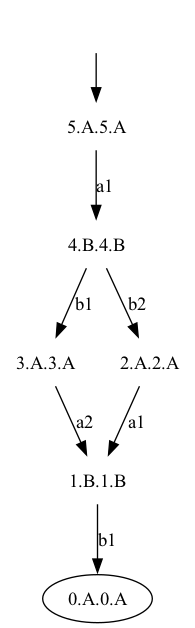

In [393]:
# YOUR CODE HERE
# Build P (the game rules)
states = {f"{n}.A" for n in range(6)} | {f"{n}.B" for n in range(6)}
init = "5.A"
events = {"a1", "a2", "b1", "b2"}
trans = set()

for n in range(6):
    if n >= 1:
        trans.add(Transition(f"{n}.A", "a1", f"{n-1}.B"))
        trans.add(Transition(f"{n}.B", "b1", f"{n-1}.A"))
    if n >= 2:
        trans.add(Transition(f"{n}.A", "a2", f"{n-2}.B"))
        trans.add(Transition(f"{n}.B", "b2", f"{n-2}.A"))

P = Automaton(states=states, init=init, events=events, trans=trans)

# Specification: A wins at 0.A (0 sticks left, A:s turn to pick)
Sp = Automaton(states=states, init=init, events=events, trans=trans, marked={"0.A"})

# Uncontrollable: B's moves
sigma_u = {"b1", "b2"}

S = supervisor(P, Sp, sigma_u)
plot_automaton(S, 'S_3_15')

In [394]:
assert type(P) is Automaton
assert type(Sp) is Automaton
assert type(S) is Automaton

assert P.states == Sp.states
assert P.events == Sp.events
assert P.init == Sp.init
assert P.trans == Sp.trans
assert P.marked == set() or P.marked == P.states
assert len(Sp.marked) == 1

- - -

Congratulations! You have reached the end of the assignment. Now,

* Save the notebook
* Upload the .ipynb file to Canvas
* Enjoy the rest of the day! 